In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
# 定义预处理列表
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 张 32x32 大小的彩色图片，这些图片共分 10 类,每类有 6000 张图像
# root:指定数据集所在位置
# train=True：表示若本地已经存在，无需下载。若不存在，则下载
# transform：预处理列表，这样就可以返回预处理后的数据集合
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=False, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=False, transform=transform)
print("训练集的图像数量为：", len(train_dataset))
print("测试集的图像数量为", len(test_dataset))

训练集的图像数量为： 50000
测试集的图像数量为 10000


In [2]:
batch_size = 4  # 设置批次个数
# shuffle=True:表示加载数据前，会先打乱数据，提高模型的稳健性
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)
test_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1b9bd9b3da0>,
 <torch.utils.data.dataloader.DataLoader at 0x1b9bd9b3da0>)

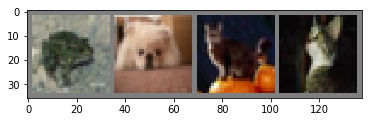

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


def imshow(img):
    # 由于加载器产生的图片是归一化后的图片，因此这里需要将图片反归一化
    # 变成归一化前的图像
    img = img / 2 + 0.5
    # 将图像从 Tensor 转为 NumPy
    npimg = img.numpy()
    # 产生的数据为 C×W×H 而 plt 展示的图像一般都是 W×H×C
    # 因此，这里会有一个维度的变换
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获得一些训练图像
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 将这些图像进行展示
imshow(torchvision.utils.make_grid(images))

In [4]:
import torch.nn.functional as F
import torch.nn as nn

# 网络模型的建立
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 神经网络的输入为 三个通道
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # 由于一共有 10 个类，因此模型的输出节点数量为 10
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        # 传入数据，且为输出数据添加激活函数
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


# 定义当前设备是否支持 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
model

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion, optimizer

(CrossEntropyLoss(), SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.001
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [41]:
'''
模型的训练
模型训练的步骤是固定的，我们只需要在编写时，注意模型的输入即可。如果是全连接神经网络，我们需要将图片转为一个行向量，即每行代表一条数据。如果是卷积神经网络，我们就可以直接将图片作为输入。当然，在输入时，我们也需要注意模型的输入大小和图片的大小是否一致。

模型训练的步骤和上一章节一致，如下：

通过模型的正向传播，输出预测结果。
通过预测结果和真实标签计算损失。
通过后向传播，获得梯度。
通过梯度更新模型的权重。
进行梯度的清空。
循环上面操作，直到损失较小为止。
'''
num_epochs = 5
# 定义数据长度
n_total_steps = len(train_loader)
print("Start training....")
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 原始数据集的大小，每个批次的大小为: [4, 3, 32, 32]
        # 将数据转为模型支持的环境类型。
        images = images.to(device)
        labels = labels.to(device)

        # 模型的正向传播，得到数据数据的预测值
        outputs = model(images)
        # 根据预测值计算损失
        loss = criterion(outputs, labels)

        # 固定步骤：梯度清空、反向传播、参数更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print(
                f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


print('Finished Training')

Start training....
Epoch [1/5], Step [2000/12500], Loss: 2.2954
Epoch [1/5], Step [4000/12500], Loss: 2.3251
Epoch [1/5], Step [6000/12500], Loss: 2.2049
Epoch [1/5], Step [8000/12500], Loss: 2.2976
Epoch [1/5], Step [10000/12500], Loss: 2.2676
Epoch [1/5], Step [12000/12500], Loss: 2.1372
Epoch [2/5], Step [2000/12500], Loss: 2.0968
Epoch [2/5], Step [4000/12500], Loss: 2.0630
Epoch [2/5], Step [6000/12500], Loss: 1.2842
Epoch [2/5], Step [8000/12500], Loss: 2.2140
Epoch [2/5], Step [10000/12500], Loss: 2.2579
Epoch [2/5], Step [12000/12500], Loss: 2.3161
Epoch [3/5], Step [2000/12500], Loss: 1.6195
Epoch [3/5], Step [4000/12500], Loss: 1.2474
Epoch [3/5], Step [6000/12500], Loss: 1.7732
Epoch [3/5], Step [8000/12500], Loss: 2.0407
Epoch [3/5], Step [10000/12500], Loss: 1.2366
Epoch [3/5], Step [12000/12500], Loss: 1.5702
Epoch [4/5], Step [2000/12500], Loss: 1.2767
Epoch [4/5], Step [4000/12500], Loss: 1.5922
Epoch [4/5], Step [6000/12500], Loss: 1.5027
Epoch [4/5], Step [8000/12500]

In [43]:
PATH = './model/cnn.pth'
torch.save(model.state_dict(), PATH)
print("The model have been saved！")

The model have been saved！


In [7]:
#模型验证

PATH = './model/cnn.pth'
new_model = ConvNet()
new_model.load_state_dict(torch.load(PATH))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
len(classes)



10

In [9]:
with torch.no_grad():
    # 统计预测正确的图像数量和进行了预测的图像数量
    n_correct = 0
    n_samples = 0
    # 统计每类图像中，预测正确的图像数量和该类图像的实际数量
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = new_model(images)
        # 利用 max 函数返回 10 个类别中概率最大的下标，即预测的类别
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        # 通过判断预测值和真实标签是否相同，来统计预测正确的样本数
        n_correct += (predicted == labels).sum().item()
        # 计算每种种类的预测正确数
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    # 输出总的模型准确率
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    # 输出每个类别的模型准确率
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 50.19 %
Accuracy of plane: 58.0 %
Accuracy of car: 58.6 %
Accuracy of bird: 33.0 %
Accuracy of cat: 40.8 %
Accuracy of deer: 31.6 %
Accuracy of dog: 46.3 %
Accuracy of frog: 50.7 %
Accuracy of horse: 65.9 %
Accuracy of ship: 56.5 %
Accuracy of truck: 60.5 %


In [46]:
'''
VGG16 模型
通过下面代码，我们可以知道 VGG16 看起来非常复杂的。
但仔细观察，该模型和上面模型的组件相同。即都是由卷积层、全连接层、激活函数、池化层等组成的。
下面代码，无需手敲，直接运行即可。当然，如果你想学的更加深入，建议还是自己推敲一下，下面代码为 VGG16 的网络结构。
'''
import torch.nn.functional as F
import torch.nn as nn

# 网络模型的建立


class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 2
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 4
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 6
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 7
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 8
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 9
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 10
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 11
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 12
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 13
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=1, stride=1),
        )
        self.classifier = nn.Sequential(
            # 14
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            # 15
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            # 16
            nn.Linear(4096, num_classes),
        )
        #self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


# 定义当前设备是否支持 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG16().to(device)
model

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [47]:
new_model = VGG16().to(device)
# 在CPU 环境下加载 GPU 运行的模型时，我们需要添加参数 `map_location='cpu'`
new_model.load_state_dict(torch.load("./model/vggcnn.pth", map_location='cpu'))
print("已加载模型")

已加载模型


In [48]:
# 重新下设置 batch_size，使模型一次能够预测更多的数据
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=125,
                                          shuffle=False)
with torch.no_grad():
    # 统计预测正确的图像数量和进行了预测的图像数量
    n_correct = 0
    n_samples = 0
    i = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = new_model(images)
        # 利用 max 函数返回 10 个类别中概率最大的下标，即预测的类别
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        # 通过判断预测值和真实标签是否相同，来统计预测正确的样本数
        n_correct += (predicted == labels).sum().item()
        if i % 10 == 0:
            print("已预测完第{}批次的数据".format(i))
        i = i+1

    # 输出总的模型准确率
    acc = 100.0 * n_correct / n_samples
    print(f'VGG模型的识别准确率为: {acc} %')

已预测完第0批次的数据
已预测完第10批次的数据
已预测完第20批次的数据
已预测完第30批次的数据
已预测完第40批次的数据
已预测完第50批次的数据
已预测完第60批次的数据
已预测完第70批次的数据
VGG模型的识别准确率为: 76.92 %
